# Problem statement
Monitoring data (BEMS & DEMS):
1. Energy (MWh)
2. Temperature (C)
3. Flow (m3/h)
4. Volume (m3)
4. Power (kw)

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
import random
from sklearn.preprocessing import OrdinalEncoder
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime
from holidays_es import Province
from heatmap import corrplot
# import pywt

# Data 
## Data loading

In [3]:
df1 = pd.read_csv('../VEOLIA/Data/UC4-2020-11to12.csv', delimiter=';', header=None, index_col=None)
df2 = pd.read_csv('../VEOLIA/Data/UC4-2021-01to03.csv', delimiter=';', header=None, index_col=None)
df3 = pd.read_csv('../VEOLIA/Data/UC4-2021-04to06.csv', delimiter=';', header=None, index_col=None)
df = pd.concat([df1, df2, df3])
df.columns = ['location', 'meter_id', 'meter_name', 'datetime', 'value']
df1.columns = ['location', 'meter_id', 'meter_name', 'datetime', 'value']
df2.columns = ['location', 'meter_id', 'meter_name', 'datetime', 'value']
df3.columns = ['location', 'meter_id', 'meter_name', 'datetime', 'value']

variables = pd.read_csv('../VEOLIA/Data/Pilot2_Variables_UC4.csv', delimiter=';')

# useful dicts
id_to_name = dict(zip(variables['ID'], variables['Variable']))
name_to_id = dict(zip(variables['Variable'], variables['ID']))

variable_to_unit = dict(zip(variables['Variable'], variables['Unit']))

print('Dataset structure')
df.head()

Dataset structure


location  meter_id  \
0  EDEN1C - M203299 - CORTES DE FUENSALDAÑA     78562   
1  EDEN1C - M203299 - CORTES DE FUENSALDAÑA     78562   
2  EDEN1C - M203299 - CORTES DE FUENSALDAÑA     78562   
3  EDEN1C - M203299 - CORTES DE FUENSALDAÑA     78562   
4  EDEN1C - M203299 - CORTES DE FUENSALDAÑA     78562   

                           meter_name                 datetime       value  
0  CONTADOR GAS CALDERA 1 (15 minuto)  2020-11-01 00:00:00.000     1623,90  
1  CONTADOR GAS CALDERA 1 (15 minuto)  2020-11-01 00:15:00.000     1623,90  
2  CONTADOR GAS CALDERA 1 (15 minuto)  2020-11-01 00:30:00.000     1637,00  
3  CONTADOR GAS CALDERA 1 (15 minuto)  2020-11-01 00:45:00.000     1649,40  
4  CONTADOR GAS CALDERA 1 (15 minuto)  2020-11-01 01:00:00.000     1661,30

## Time variable conversion

The datetime columnn is converted to datetime.datetime type.

In [4]:
def to_datetime(x):
    if not isinstance(x, float):
        return datetime.strptime("".join(str(x)), '%Y-%m-%d %H:%M:%S.%f')
    return np.nan
    
df['datetime'] = df['datetime'].apply(lambda x : to_datetime(x))
df.head()

location  meter_id  \
0  EDEN1C - M203299 - CORTES DE FUENSALDAÑA     78562   
1  EDEN1C - M203299 - CORTES DE FUENSALDAÑA     78562   
2  EDEN1C - M203299 - CORTES DE FUENSALDAÑA     78562   
3  EDEN1C - M203299 - CORTES DE FUENSALDAÑA     78562   
4  EDEN1C - M203299 - CORTES DE FUENSALDAÑA     78562   

                           meter_name            datetime       value  
0  CONTADOR GAS CALDERA 1 (15 minuto) 2020-11-01 00:00:00     1623,90  
1  CONTADOR GAS CALDERA 1 (15 minuto) 2020-11-01 00:15:00     1623,90  
2  CONTADOR GAS CALDERA 1 (15 minuto) 2020-11-01 00:30:00     1637,00  
3  CONTADOR GAS CALDERA 1 (15 minuto) 2020-11-01 00:45:00     1649,40  
4  CONTADOR GAS CALDERA 1 (15 minuto) 2020-11-01 01:00:00     1661,30

Unfortunately we can see that not all dataframes contain all variables:

In [5]:
initial_variables = df1['meter_name'].unique()
all_variables = df3['meter_name'].unique()
print('7 Variables for 11-12/2020:\n', initial_variables)
print('7 Variables for 01-03/2021\n', df2['meter_name'].unique())
print('Variables for 04-06/2020\n', all_variables)

7 Variables for 11-12/2020:
 ['CONTADOR GAS CALDERA 1 (15 minuto)' 'CONTADOR GAS CALDERA 2 (15 minuto)'
 'Energía Caldera 1 (15 minuto)' 'Energía Caldera 2 (15 minuto)'
 'Energía Primario ACS (15 minuto)' 'Energía Consumo ACS (15 minuto)'
 'Energia Activa Total (15 minuto)']
7 Variables for 01-03/2021
 ['CONTADOR GAS CALDERA 1 (15 minuto)' 'CONTADOR GAS CALDERA 2 (15 minuto)'
 'Energía Caldera 1 (15 minuto)' 'Energía Caldera 2 (15 minuto)'
 'Energía Primario ACS (15 minuto)' 'Energía Consumo ACS (15 minuto)'
 'Energia Activa Total (15 minuto)']
Variables for 04-06/2020
 ['TEMPERATURA EXTERIOR (15 minuto)' 'CONTADOR GAS CALDERA 1 (15 minuto)'
 'CONTADOR GAS CALDERA 2 (15 minuto)' 'Energía Caldera 1 (15 minuto)'
 'Caudal Caldera 1 (15 minuto)'
 'TEMPERATURA COLECTOR IMPULSION (15 minuto)'
 'Volumen Caldera 1 (15 minuto)' 'Potencia Caldera 1 (15 minuto)'
 'Temper Impulsion Caldera 1 (15 minuto)'
 'Temper Retorno Caldera 1 (15 minuto)' 'Energía Caldera 2 (15 minuto)'
 'Caudal Caldera 2 (15

This is the crucial date where the extra variables are added to the dataset. New variables are added the 14th of May 2021 at 09:15:00am. From then on the dataset is full.

In [6]:
print("Number of variables before 14/5/2021 09:15:00:", df[df.datetime < datetime(2021, 5, 14, 9, 15, 0)]['meter_id'].unique().shape[0])
print("Number of variables on 14/5/2021 after 09:15:00:", df[(df.datetime >= datetime(2021, 5, 14, 9, 15, 0)) & (df.datetime < datetime(2021, 5, 14, 9, 30, 0))]['meter_id'].unique().shape[0])
print("Number of variables on 15/5/2021:", df[df.datetime == datetime(2021, 5, 15)]['meter_id'].unique().shape[0])
print("Number of variables after 15/5/2021:", df[df.datetime > datetime(2021, 5, 15)]['meter_id'].unique().shape[0])

Number of variables before 14/5/2021 09:15:00: 7
Number of variables on 14/5/2021 after 09:15:00: 36
Number of variables on 15/5/2021: 36
Number of variables after 15/5/2021: 36


The new variables added are the following 29:

In [7]:
allvars = set(df3['meter_name'].unique())
oldvars =  set(df1['meter_name'].unique())
new_variables = list(allvars - oldvars)
new_variables

['Volumen Primario ACS (15 minuto)',
 'TEMPERATURA DEPOSITO 1 ACS (15 minuto)',
 'Temper Impulsion Consumo ACS (15 minuto)',
 'Potencia Caldera 2 (15 minuto)',
 'Temper Impulsion Primario ACS (15 minuto)',
 'TEMPERATURA IMPULSION CALEFACC (15 minuto)',
 'Potencia Consumo ACS (15 minuto)',
 'Caudal Caldera 2 (15 minuto)',
 'Temper Retorno Consumo ACS (15 minuto)',
 'Volumen Caldera 1 (15 minuto)',
 'Caudal Caldera 1 (15 minuto)',
 'Temper Retorno Caldera 2 (15 minuto)',
 'Caudal Consumo ACS (15 minuto)',
 'TEMPERATUR COLECTOR RETORNO (15 minuto)',
 'DEMANDA QUEMADORES (15 minuto)',
 'Potencia Caldera 1 (15 minuto)',
 'TEMPERATURA COLECTOR IMPULSION (15 minuto)',
 'TEMPERATURA EXTERIOR (15 minuto)',
 'Temper Retorno Caldera 1 (15 minuto)',
 'Temper Retorno Primario ACS (15 minuto)',
 'Volumen Caldera 2 (15 minuto)',
 'Temper Impulsion Caldera 1 (15 minuto)',
 'DEMANDA CALEFACCIÓN (15 minuto)',
 'Volumen Consumo ACS (15 minuto)',
 'Potencia Primario ACS (15 minuto)',
 'DEMANDA ACS (15 min

## Missing data
No missing data initially but there gonna be injected soon.

In [8]:
print("Total number of rows containing missing value:")
print(df.isna().sum().sum())

Total number of rows containing missing value:
0


## Time series dataset creation
First of all a dictionary of dataframes is created. Each dataframe refers to one meter / variable and contains the columns: datetime & value. Thus we now have as many timeseries datasets as the number of meters which need to be concatenated to form a unified timeseries dataset of all variables (meters). Outer join is performed so that variables that do not take values at all timesteps are retained and filled with a NaN value.

In [9]:
df['meter_name'].unique()

ts_dict = {}

for meter_name in df['meter_name'].unique():
    ts_dict[meter_name] = df[df['meter_id'] == name_to_id[meter_name]][['datetime', 'value']]
    ts_dict[meter_name].columns = ['datetime', meter_name]
ts_dict

ts = pd.DataFrame(columns=['datetime', 'nothing'])
for var in ts_dict:
    ts = pd.merge(ts, ts_dict[var], on='datetime',how='outer')

ts.drop(columns=['nothing'], inplace=True)

# datetime as index
ts.index = ts['datetime']
unique_dates = ts['datetime']
ts.drop(columns=['datetime'], inplace=True)

# string to float
ts = ts.apply(lambda x: x.str.replace(',','.'))
for col in ts.columns:
    ts[col] = pd.to_numeric(ts[col])

ts.head()

CONTADOR GAS CALDERA 1 (15 minuto)  \
datetime                                                  
2020-11-01 00:00:00                              1623.9   
2020-11-01 00:15:00                              1623.9   
2020-11-01 00:30:00                              1637.0   
2020-11-01 00:45:00                              1649.4   
2020-11-01 01:00:00                              1661.3   

                     CONTADOR GAS CALDERA 2 (15 minuto)  \
datetime                                                  
2020-11-01 00:00:00                              3290.1   
2020-11-01 00:15:00                              3290.1   
2020-11-01 00:30:00                              3296.1   
2020-11-01 00:45:00                              3296.1   
2020-11-01 01:00:00                              3296.1   

                     Energía Caldera 1 (15 minuto)  \
datetime                                             
2020-11-01 00:00:00                          33.91   
2020-11-01 00:15:00                          33.91   
2020-11-01 00:30:00                          33.92   
2020-11-01 00:45:00                          33.93   
2020-11-01 01:00:00                          33.94   

                     Energía Caldera 2 (15 minuto)  \
datetime                                             
2020-11-01 00:00:00                          43.26   
2020-11-01 00:15:00                          43.26   
2020-11-01 00:30:00                          43.27   
2020-11-01 00:45:00                          43.27   
2020-11-01 01:00:00                          43.27   

                     Energía Primario ACS (15 minuto)  \
datetime                                                
2020-11-01 00:00:00                              1.54   
2020-11-01 00:15:00                              1.54   
2020-11-01 00:30:00                              1.55   
2020-11-01 00:45:00                              1.56   
2020-11-01 01:00:00                              1.57   

                     Energía Consumo ACS (15 minuto)  \
datetime                                               
2020-11-01 00:00:00                              0.0   
2020-11-01 00:15:00                              0.0   
2020-11-01 00:30:00                              0.0   
2020-11-01 00:45:00                              0.0   
2020-11-01 01:00:00                              0.0   

                     Energia Activa Total (15 minuto)  \
datetime                                                
2020-11-01 00:00:00                               NaN   
2020-11-01 00:15:00                               NaN   
2020-11-01 00:30:00                               NaN   
2020-11-01 00:45:00                               NaN   
2020-11-01 01:00:00                               NaN   

                     TEMPERATURA EXTERIOR (15 minuto)  \
datetime                                                
2020-11-01 00:00:00                               NaN   
2020-11-01 00:15:00                               NaN   
2020-11-01 00:30:00                               NaN   
2020-11-01 00:45:00                               NaN   
2020-11-01 01:00:00                               NaN   

                     Caudal Caldera 1 (15 minuto)  \
datetime                                            
2020-11-01 00:00:00                           NaN   
2020-11-01 00:15:00                           NaN   
2020-11-01 00:30:00                           NaN   
2020-11-01 00:45:00                           NaN   
2020-11-01 01:00:00                           NaN   

                     TEMPERATURA COLECTOR IMPULSION (15 minuto)  ...  \
datetime                                                         ...   
2020-11-01 00:00:00                                         NaN  ...   
2020-11-01 00:15:00                                         NaN  ...   
2020-11-01 00:30:00                                         NaN  ...   
2020-11-01 00:45:00                                         NaN  ...   
2020-11-01 01:00:00                   

As timeseries do not share all the time range from 11/20 to 06/21 NaNs are used to fill the gaps. Something good to observe is that datetime column consists of 23232 datetimes which is exactly what we should observe for 4 quarters x 24 hours x n_days where n_days = 30 (Nov) + 31 (Dec) + 31 (Jan) + 28 + 31 + 30 + 31 + 30 (June) = 23232 quarterly timesteps.

## Remove invalid data
Negative values are also replaced by NaN as they are wrong for sure

In [10]:
# remove negative values
ts[ts < 0] = np.nan

### Load variables creation

In this section some new time series are created from differentiating the energy time series in order to create new mean power time series that are available for all 6 months and can be useful for forecasts. These time series lack in terms of precision as the smallest decimal point refers to 1/100 MWh which leads to a precision of 10kw in contrast to pure power meters that offer precision of 0,01 kW. However in terms of total loads (where precision is less important) they are expected to provide useful forecasts 

In [11]:
ts["Diff Load Activa Total (15 minuto)"] = ts["Energia Activa Total (15 minuto)"].diff()
ts["Diff Load Primario ACS (15 minuto)"] = ts["Energía Primario ACS (15 minuto)"].diff()
ts["Diff Load Consumo ACS (15 minuto)"] = ts["Energía Consumo ACS (15 minuto)"].diff()
ts["Diff Load Caldera 1 (15 minuto)"] = ts["Energía Caldera 1 (15 minuto)"].diff()
ts["Diff Load Caldera 2 (15 minuto)"] = ts["Energía Caldera 2 (15 minuto)"].diff()

### Conversion of mean power (kw) to energy (Mwh)
To later compare differentiated energies (average 15min loads) with respective measured powers we need to convert power to 15min loads. The conversion is kw to Mwh for a timestep of 15 min so we need to divide powers by 4 * 1000. This conversion creates the final version of the 15 min timestep dataset

In [12]:
def power_to_mean_load_kwh(x):
    return x / 4

def mwh_to_kwh(x):
    return x * 1000

ts_new = ts[ts.filter(regex="Potencia").columns].apply(lambda x: power_to_mean_load_kwh(x))
ts_new.columns = [i.replace("Potencia", "True Load") for i in ts_new.columns]

ts15 = pd.concat([ts, ts_new], axis=1)
ts15[ts.filter(regex="Diff Load").columns] = ts15[ts15.filter(regex="Diff Load").columns].apply(lambda x: mwh_to_kwh(x))

# drop potencia true loads have been created instead
ts15.drop(columns=ts15.filter(like='Potencia'), inplace=True)
ts15.to_csv("../VEOLIA/artifacts/timeseries_15min.csv")

#update units dict
new_cols = ts15.filter(like='Diff').columns.tolist() + ts15.filter(like='True').columns.tolist()
new_var_to_unit = {c:'kWh' for c in new_cols}
variable_to_unit.update(new_var_to_unit)

print('30min dataset:')
ts15.head(3)

30min dataset:


CONTADOR GAS CALDERA 1 (15 minuto)  \
datetime                                                  
2020-11-01 00:00:00                              1623.9   
2020-11-01 00:15:00                              1623.9   
2020-11-01 00:30:00                              1637.0   

                     CONTADOR GAS CALDERA 2 (15 minuto)  \
datetime                                                  
2020-11-01 00:00:00                              3290.1   
2020-11-01 00:15:00                              3290.1   
2020-11-01 00:30:00                              3296.1   

                     Energía Caldera 1 (15 minuto)  \
datetime                                             
2020-11-01 00:00:00                          33.91   
2020-11-01 00:15:00                          33.91   
2020-11-01 00:30:00                          33.92   

                     Energía Caldera 2 (15 minuto)  \
datetime                                             
2020-11-01 00:00:00                          43.26   
2020-11-01 00:15:00                          43.26   
2020-11-01 00:30:00                          43.27   

                     Energía Primario ACS (15 minuto)  \
datetime                                                
2020-11-01 00:00:00                              1.54   
2020-11-01 00:15:00                              1.54   
2020-11-01 00:30:00                              1.55   

                     Energía Consumo ACS (15 minuto)  \
datetime                                               
2020-11-01 00:00:00                              0.0   
2020-11-01 00:15:00                              0.0   
2020-11-01 00:30:00                              0.0   

                     Energia Activa Total (15 minuto)  \
datetime                                                
2020-11-01 00:00:00                               NaN   
2020-11-01 00:15:00                               NaN   
2020-11-01 00:30:00                               NaN   

                     TEMPERATURA EXTERIOR (15 minuto)  \
datetime                                                
2020-11-01 00:00:00                               NaN   
2020-11-01 00:15:00                               NaN   
2020-11-01 00:30:00                               NaN   

                     Caudal Caldera 1 (15 minuto)  \
datetime                                            
2020-11-01 00:00:00                           NaN   
2020-11-01 00:15:00                           NaN   
2020-11-01 00:30:00                           NaN   

                     TEMPERATURA COLECTOR IMPULSION (15 minuto)  ...  \
datetime                                                         ...   
2020-11-01 00:00:00                                         NaN  ...   
2020-11-01 00:15:00                                         NaN  ...   
2020-11-01 00:30:00                                         NaN  ...   

                     DEMANDA QUEMADORES (15 minuto)  \
datetime                                              
2020-11-01 00:00:00                             NaN   
2020-11-01 00:15:00                             NaN   
2020-11-01 00:30:00                             NaN   

                     Diff Load Activa Total (15 minuto)  \
datetime                                                  
2020-11-01 00:00:00                                 NaN   
2020-11-01 00:15:00                                 NaN   
2020-11-01 00:30:00                                 NaN   

                     Diff Load Primario ACS (15 minuto)  \
datetime                                                  
2020-11-01 00:00:00                                 NaN   
2020-11-01 00:15:00                                 0.0   
2020-11-01 00:30:00                                10.0   

                     Diff Load Consumo ACS (15 minuto)  \
datetime                                                 
2020-11-01 00:00:00                                NaN   
2020-11-01 00:15:00                                0.0   
2020-11-01 00:30:00  

### Resampling
We create a new load only dataset and change its timestep to 30min and 60min in order to render diff loads more similar to true loads. For cumulative measurements (loads, energies) aggregation should be sum. For the rest of measurements (flows, temperature, powers) we need to consider a mean aggregator.

In [13]:
load30 = ts15.filter(like='Load').resample('30T').sum()
energy30 = ts15.filter(like='Energ').resample('30T').sum()
volume30 = ts15.filter(like='Volumen').resample('30T').sum()
power30 = ts15.filter(like='Potencia').resample('30T').mean()
temp30 = ts15.filter(regex='Temp|TEMP').resample('30T').mean()
demanda30 = ts15.filter(like='Demanda').resample('30T').mean()
flow30 = ts15.filter(like='Caudal').resample('30T').mean()
contador30 = ts15.filter(like='CONTADOR').resample('30T').sum()
ts30 = pd.concat([load30, energy30, volume30, power30, temp30, demanda30, flow30, contador30], axis=1)
ts30.columns = [col.replace('15', '30') for col in ts30.columns]

# drop potencia as s true loads have been created instead
ts30.drop(columns=ts30.filter(like='Potencia'), inplace=True)
ts30.to_csv("../VEOLIA/artifacts/timeseries_30min.csv")

print('30min dataset:')
ts30.head()

30min dataset:


Diff Load Activa Total (30 minuto)  \
datetime                                                  
2020-11-01 00:00:00                                 0.0   
2020-11-01 00:30:00                                 0.0   
2020-11-01 01:00:00                                 0.0   
2020-11-01 01:30:00                                 0.0   
2020-11-01 02:00:00                                 0.0   

                     Diff Load Primario ACS (30 minuto)  \
datetime                                                  
2020-11-01 00:00:00                                 0.0   
2020-11-01 00:30:00                                20.0   
2020-11-01 01:00:00                                20.0   
2020-11-01 01:30:00                                20.0   
2020-11-01 02:00:00                                10.0   

                     Diff Load Consumo ACS (30 minuto)  \
datetime                                                 
2020-11-01 00:00:00                                0.0   
2020-11-01 00:30:00                                0.0   
2020-11-01 01:00:00                                0.0   
2020-11-01 01:30:00                                0.0   
2020-11-01 02:00:00                                0.0   

                     Diff Load Caldera 1 (30 minuto)  \
datetime                                               
2020-11-01 00:00:00                              0.0   
2020-11-01 00:30:00                             20.0   
2020-11-01 01:00:00                             20.0   
2020-11-01 01:30:00                             20.0   
2020-11-01 02:00:00                             20.0   

                     Diff Load Caldera 2 (30 minuto)  \
datetime                                               
2020-11-01 00:00:00                              0.0   
2020-11-01 00:30:00                             10.0   
2020-11-01 01:00:00                              0.0   
2020-11-01 01:30:00                              0.0   
2020-11-01 02:00:00                              0.0   

                     True Load Caldera 1 (30 minuto)  \
datetime                                               
2020-11-01 00:00:00                              0.0   
2020-11-01 00:30:00                              0.0   
2020-11-01 01:00:00                              0.0   
2020-11-01 01:30:00                              0.0   
2020-11-01 02:00:00                              0.0   

                     True Load Caldera 2 (30 minuto)  \
datetime                                               
2020-11-01 00:00:00                              0.0   
2020-11-01 00:30:00                              0.0   
2020-11-01 01:00:00                              0.0   
2020-11-01 01:30:00                              0.0   
2020-11-01 02:00:00                              0.0   

                     True Load Primario ACS (30 minuto)  \
datetime                                                  
2020-11-01 00:00:00                                 0.0   
2020-11-01 00:30:00                                 0.0   
2020-11-01 01:00:00                                 0.0   
2020-11-01 01:30:00                                 0.0   
2020-11-01 02:00:00                                 0.0   

                     True Load Consumo ACS (30 minuto)  \
datetime                                                 
2020-11-01 00:00:00                                0.0   
2020-11-01 00:30:00                                0.0   
2020-11-01 01:00:00                                0.0   
2020-11-01 01:30:00                                0.0   
2020-11-01 02:00:00                                0.0   

                     Energía Caldera 1 (30 minuto)  ...  \
datetime                                            ...   
2020-11-01 00:00:00                          67.82  ...   
2020-11-01 00:30:00                          67.85  ...   
2020-11-01 01:00:00                          67.89  ...   
2020-11-01 01:30:00                          67.93  ...   
2020-11-01 02:00:00                    

In [14]:
load60 = ts15.filter(like='Load').resample('60T').sum()
energy60 = ts15.filter(like='Energ').resample('60T').sum()
volume60 = ts15.filter(like='Volumen').resample('60T').sum()
power60 = ts15.filter(like='Potencia').resample('60T').mean()
temp60 = ts15.filter(regex='Temp|TEMP').resample('60T').mean()
demanda60 = ts15.filter(like='Demanda').resample('60T').mean()
flow60 = ts15.filter(like='Caudal').resample('60T').mean()
contador60 = ts15.filter(like='CONTADOR').resample('60T').mean()
ts60 = pd.concat([load60, energy60, volume60, power60, temp60, demanda60, flow60, contador60], axis=1)
ts60.columns = [col.replace('15', '60') for col in ts60.columns]

# drop potencia as s true loads have been created instead
ts60.drop(columns=ts60.filter(like='Potencia'), inplace=True)
ts60.to_csv("../VEOLIA/artifacts/timeseries_60min.csv")

print('60min dataset:')
ts60.to_csv("../VEOLIA/artifacts/timeseries_60min.csv")
ts60.head()

60min dataset:


Diff Load Activa Total (60 minuto)  \
datetime                                                  
2020-11-01 00:00:00                                 0.0   
2020-11-01 01:00:00                                 0.0   
2020-11-01 02:00:00                                 0.0   
2020-11-01 03:00:00                                 0.0   
2020-11-01 04:00:00                                 0.0   

                     Diff Load Primario ACS (60 minuto)  \
datetime                                                  
2020-11-01 00:00:00                                20.0   
2020-11-01 01:00:00                                40.0   
2020-11-01 02:00:00                                20.0   
2020-11-01 03:00:00                                 0.0   
2020-11-01 04:00:00                                 0.0   

                     Diff Load Consumo ACS (60 minuto)  \
datetime                                                 
2020-11-01 00:00:00                                0.0   
2020-11-01 01:00:00                                0.0   
2020-11-01 02:00:00                                0.0   
2020-11-01 03:00:00                                0.0   
2020-11-01 04:00:00                                0.0   

                     Diff Load Caldera 1 (60 minuto)  \
datetime                                               
2020-11-01 00:00:00                             20.0   
2020-11-01 01:00:00                             40.0   
2020-11-01 02:00:00                             30.0   
2020-11-01 03:00:00                              0.0   
2020-11-01 04:00:00                              0.0   

                     Diff Load Caldera 2 (60 minuto)  \
datetime                                               
2020-11-01 00:00:00                             10.0   
2020-11-01 01:00:00                              0.0   
2020-11-01 02:00:00                              0.0   
2020-11-01 03:00:00                              0.0   
2020-11-01 04:00:00                              0.0   

                     True Load Caldera 1 (60 minuto)  \
datetime                                               
2020-11-01 00:00:00                              0.0   
2020-11-01 01:00:00                              0.0   
2020-11-01 02:00:00                              0.0   
2020-11-01 03:00:00                              0.0   
2020-11-01 04:00:00                              0.0   

                     True Load Caldera 2 (60 minuto)  \
datetime                                               
2020-11-01 00:00:00                              0.0   
2020-11-01 01:00:00                              0.0   
2020-11-01 02:00:00                              0.0   
2020-11-01 03:00:00                              0.0   
2020-11-01 04:00:00                              0.0   

                     True Load Primario ACS (60 minuto)  \
datetime                                                  
2020-11-01 00:00:00                                 0.0   
2020-11-01 01:00:00                                 0.0   
2020-11-01 02:00:00                                 0.0   
2020-11-01 03:00:00                                 0.0   
2020-11-01 04:00:00                                 0.0   

                     True Load Consumo ACS (60 minuto)  \
datetime                                                 
2020-11-01 00:00:00                                0.0   
2020-11-01 01:00:00                                0.0   
2020-11-01 02:00:00                                0.0   
2020-11-01 03:00:00                                0.0   
2020-11-01 04:00:00                                0.0   

                     Energía Caldera 1 (60 minuto)  ...  \
datetime                                            ...   
2020-11-01 00:00:00                         135.67  ...   
2020-11-01 01:00:00                         135.82  ...   
2020-11-01 02:00:00                         135.98  ...   
2020-11-01 03:00:00                         136.00  ...   
2020-11-01 04:00:00                    

### Creation of auxiliary calendar information dataset
In this section a calendar is created containing auxiliary info for all unique dates that appear in the core dataset. Holidays are exracted for the province of Valladolid using the holiday-es python package.

In [15]:
def isholiday(x, holiday_list):
    if x in holiday_list:
        return True
    return False

def isweekend(x):
    if x == 6 or x ==0:
        return True
    return False

def create_calendar(timestep_minutes):
    unique_dates = {'15':ts15, '30': ts30, '60': ts60}
    calendar = pd.DataFrame(unique_dates[str(timestep_minutes)].index.tolist(), columns=['datetime'])
    calendar['year'] = calendar['datetime'].apply(lambda x : x.year)
    calendar['month'] = calendar['datetime'].apply(lambda x : x.month)
    calendar['day'] = calendar['datetime'].apply(lambda x : x.day)
    calendar['hour'] = calendar['datetime'].apply(lambda x : x.hour)
    calendar['minute'] = calendar['datetime'].apply(lambda x : x.minute)
    calendar['second'] = calendar['datetime'].apply(lambda x : x.second)
    calendar['weekday'] = calendar['datetime'].apply(lambda x : x.weekday())
    calendar['weekend'] = calendar['weekday'].apply(lambda x: isweekend(x))

    national_holidays = Province(name="valladolid").national_holidays()
    regional_holidays = Province(name="valladolid").regional_holidays()
    local_holidays = Province(name="valladolid").local_holidays()
    holiday_list = national_holidays + regional_holidays + local_holidays
    calendar['holiday'] = calendar['datetime'].apply(lambda x : isholiday(x.date(), holiday_list))
    return calendar 

calendar = create_calendar(15)
print("15 min Calendar dataset structure:")
calendar.head()

15 min Calendar dataset structure:


datetime  year  month  day  hour  minute  second  weekday  \
0 2020-11-01 00:00:00  2020     11    1     0       0       0        6   
1 2020-11-01 00:15:00  2020     11    1     0      15       0        6   
2 2020-11-01 00:30:00  2020     11    1     0      30       0        6   
3 2020-11-01 00:45:00  2020     11    1     0      45       0        6   
4 2020-11-01 01:00:00  2020     11    1     1       0       0        6   

   weekend  holiday  
0     True    False  
1     True    False  
2     True    False  
3     True    False  
4     True    False

As only 7 holidays are included in our study period we observe 672 rows that have the holiday variable set to True. This happens because every day has 24x4 quarterly timesteps and 24x4x7 = 672 

In [16]:
print('Total quarterly records with True holiday label')
calendar['holiday'].sum()

Total quarterly records with True holiday label


672

At this point mixed dataset (timeseries + calendar features) are also created.

In [17]:
ts15_plus_time = pd.merge(ts15, create_calendar(15), how='left',left_index=True,right_on='datetime').set_index('datetime')
ts15_plus_time.to_csv("../VEOLIA/artifacts/timeseries_plus_time_15min.csv")
ts30_plus_time = pd.merge(ts30, create_calendar(30), how='left',left_index=True,right_on='datetime').set_index('datetime')
ts30_plus_time.to_csv("../VEOLIA/artifacts/timeseries_plus_time_30min.csv")
ts60_plus_time = pd.merge(ts60, create_calendar(60), how='left',left_index=True,right_on='datetime').set_index('datetime')
ts60_plus_time.to_csv("../VEOLIA/artifacts/timeseries_plus_time_60min.csv")

# EDA

## Calendar EDA

In [18]:
calendar.head(3)

datetime  year  month  day  hour  minute  second  weekday  \
0 2020-11-01 00:00:00  2020     11    1     0       0       0        6   
1 2020-11-01 00:15:00  2020     11    1     0      15       0        6   
2 2020-11-01 00:30:00  2020     11    1     0      30       0        6   

   weekend  holiday  
0     True    False  
1     True    False  
2     True    False

We validate again that no timesteps are missing from the dataset by ensuring that no time difference amongst successive timesteps is larger than 15 minutes

In [19]:
diffs = calendar['datetime'].diff()
diffs[diffs > pd.Timedelta('15M')]

/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


Series([], Name: datetime, dtype: timedelta64[ns])

/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


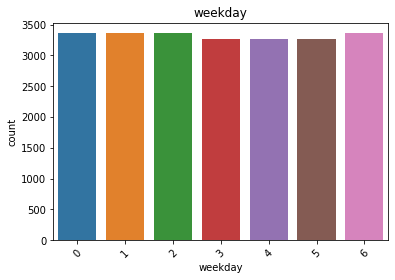

/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


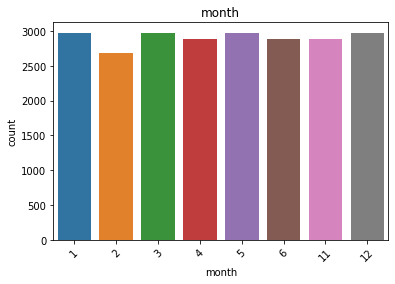

/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


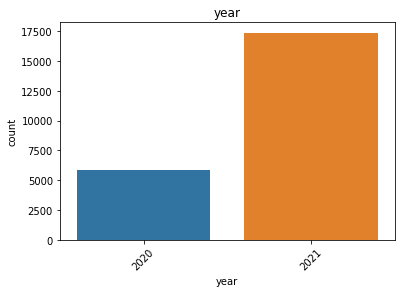

/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


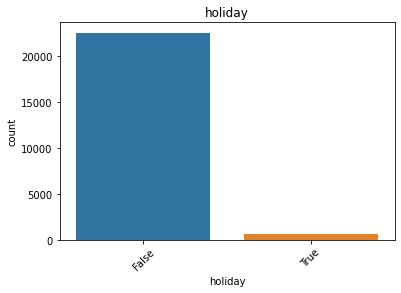

In [20]:
for col in ['weekday','month', 'year', 'holiday']:
    sns.countplot(calendar[col])
    plt.title(col)
    plt.xticks(rotation=45)
    plt.show()

### Observations from calendar EDA
1. We have data for all the weekdays without equal counts though. However, data starts on Saturday (6) and ends on Tuesday (2) so this is expected.
2. Month data quantity is fluctuating according to fluctuation of days of each month (28, 30. 31)
3. As we have 6 month data from 2021 and 2 from 2020 the year distribution looks OK.
4. Same thing for the 7 holidays in total that are observed in our dataset.

# Time series dataset EDA

## Distribution plots (histogram + density + cumulative density) for all variables:

In [27]:
 # pdfs
print("PDFs")
fig, axs = plt.subplots(nrows=7, ncols=6, figsize=(30, 40))
i=0
j=0
for col in ts15.columns:
    if j ==6:
        j = 0
        i += 1
    ax = sns.histplot(x=ts15[col], kde=True, ax=axs[i, j])
    plt.title(f'PDF - {col}')
    plt.xticks(rotation=45)
    ax.set(xlabel=variable_to_unit[col])
    plt.grid()
    # plt.savefig(f"./figures/{col}_pdf")
    j += 1
plt.savefig(f"./figures/PDFs")
plt.show()


PDFs


CDFs


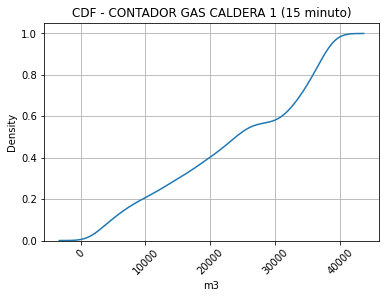

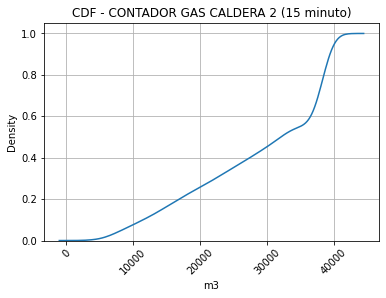

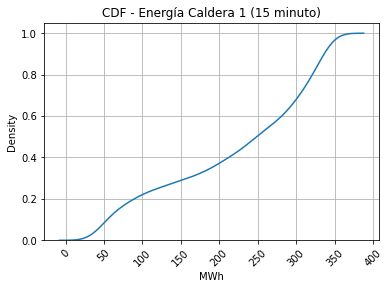

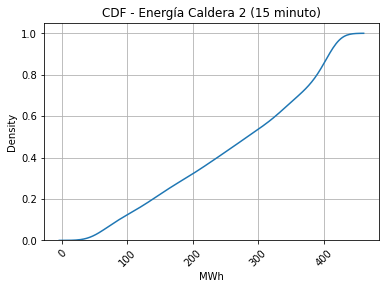

KeyboardInterrupt: 

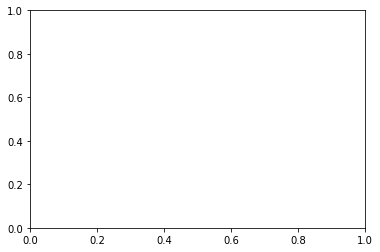

In [22]:
 # pdfs
print("PDFs")
fig, axs = plt.subplots(nrows=7, ncols=6, figsize=(30, 40))
i=0
j=0
for col in ts15.columns:
    if j ==6:
        j = 0
        i += 1
    ax = sns.histplot(x=ts15[col], kde=True, ax=axs[i, j])
    plt.title(f'PDF - {col}')
    plt.xticks(rotation=45)
    ax.set(xlabel=variable_to_unit[col])
    plt.grid()
    plt.savefig(f"./figures/{col}_pdf")
    j += 1
plt.show()

## Original time series plots

### Gas meters
Normally here we would observe purely increasing trends but probably the counters were reset in late November 2020. Unit is cubic meters (m3)

In [ ]:
# gas meters
fig = px.line(ts, x=ts15.index, y=ts15[initial_variables].filter(like="CONTADOR").columns, title='Gas meters (m3)')
fig.show()

### Energy meters
- **Total active energy:** Here we observe a purely increasing pattern as expected. Trend is almost linear with time. Skewness is a bit increased during the winter months denoting a bit higher energy amounts.
- **Individual energies:** Here we observe a purely increasing patterns as expected except for the consumed energy of the ACS whose meter seems inactive until mid December 2020. Boilers obviously drop their consumptions during spring and summer months

In [ ]:
fig = px.line(ts, x=ts.index, y=ts.filter(like="Energ").columns, title='Energy variables (MWh)')
fig.show()


### Machine Temperatures
Machine temperatures are captured from mid May and after... Not many things to observe for now except for the pure daily patterns that are visible in the graph due to the small sample size.

In [ ]:
fig = px.line(ts, x=ts.index, y=ts.filter(regex="Temper|TEMPER").columns, title='Machine Temperatures (°C)')
fig.show()


### True loads 
True loads are extracted from average powers (multiplication with time [kw to kwh])

In [ ]:
fig = px.line(ts, x=ts.index, y=ts.filter(like="True Load").columns, title='Power (kWh)')
fig.show()

### Flow

In [ ]:
fig = px.line(ts, x=ts.index, y=ts.filter(like="Caudal").columns, title='Flow (m3/h)')
fig.show()

### Volumes

In [ ]:
fig = px.line(ts, x=ts.index, y=ts.filter(like="Volume").columns, title='Volumes (m3)')
fig.show()

### Demandas

In [ ]:
fig = px.line(ts, x=ts.index, y=ts.filter(like="DEMANDA").columns, title='Demandas (°C)')
fig.show()

## Load time series (differentiated energy time series) plots

We can observe that the total active load is much larger than the other variables so it is also summed up by other variables too.

In [142]:
fig = px.line(ts15, x=ts15.index, y=ts.filter(like='Diff Load').columns, title='Average Diff Loads (kWh)')
fig.show()

### Comparison with power measurements
To compare differentiated energies (average 15min loads) with respective measured powers we need to convert power to 15min loads. The conversion is kw to Mwh for a timestep of 15 min so we need to divide powers by 4 * 1000.

In [ ]:
columns=ts15.filter(like="Diff Load").columns.tolist() + ts15.filter(like="True Load").columns.tolist()
fig = px.line(ts15, x=ts15.index, y=columns, title='Average Loads (kWh)')
fig.show()

In [ ]:
ts15[["True Load Caldera 1 (15 minuto)", "Diff Load Caldera 1 (15 minuto)"]].tail(20)
ts15[["True Load Consumo ACS (15 minuto)", "Diff Load Consumo ACS (15 minuto)"]].tail(20)

### Comparison with power measurements for 30min dataset

In [ ]:
columns=ts30.filter(like="Diff Load").columns.tolist() + ts30.filter(like="True Load").columns.tolist()
fig = px.line(ts30, x=ts30.index, y=columns, title='Average Loads 30min (Differentiation vs True) [kWh]')
fig.show()

In [ ]:
ts30[["True Load Caldera 1 (30 minuto)", "Diff Load Caldera 1 (30 minuto)"]].tail(20)

### Comparison with power measurements for 1 hour dataset

In [ ]:
columns=ts60.filter(like="Diff Load").columns.tolist() + ts60.filter(like="True Load").columns.tolist()
fig = px.line(ts60, x=ts60.index, y=columns, title='Average Loads 60min (Differentiation vs True) [kWh]')
fig.show()

In [114]:
ts60[["True Load Caldera 1 (60 minuto)", "Diff Load Caldera 1 (60 minuto)"]].tail(20)

True Load Caldera 1 (60 minuto)  \
datetime                                               
2021-06-30 04:00:00                          10.1475   
2021-06-30 05:00:00                          10.3950   
2021-06-30 06:00:00                          16.0875   
2021-06-30 07:00:00                          16.0875   
2021-06-30 08:00:00                          25.4900   
2021-06-30 09:00:00                          23.0150   
2021-06-30 10:00:00                           9.6525   
2021-06-30 11:00:00                          50.9825   
2021-06-30 12:00:00                          23.2625   
2021-06-30 13:00:00                          16.8300   
2021-06-30 14:00:00                          20.0475   
2021-06-30 15:00:00                          30.4425   
2021-06-30 16:00:00                          23.0150   
2021-06-30 17:00:00                          20.2950   
2021-06-30 18:00:00                          20.0475   
2021-06-30 19:00:00                           9.4050   
2021-06-30 20:00:00                           9.4050   
2021-06-30 21:00:00                          19.5525   
2021-06-30 22:00:00                          34.8925   
2021-06-30 23:00:00                          27.2200   

                     Diff Load Caldera 1 (60 minuto)  
datetime                                              
2021-06-30 04:00:00                             20.0  
2021-06-30 05:00:00                             10.0  
2021-06-30 06:00:00                             20.0  
2021-06-30 07:00:00                             20.0  
2021-06-30 08:00:00                             30.0  
2021-06-30 09:00:00                             10.0  
2021-06-30 10:00:00                             10.0  
2021-06-30 11:00:00                             50.0  
2021-06-30 12:00:00                             10.0  
2021-06-30 13:00:00                             20.0  
2021-06-30 14:00:00                             30.0  
2021-06-30 15:00:00                             20.0  
2021-06-30 16:00:00                             20.0  
2021-06-30 17:00:00                             30.0  
2021-06-30 18:00:00                             20.0  
2021-06-30 19:00:00                             10.0  
2021-06-30 20:00:00                             10.0  
2021-06-30 21:00:00                             20.0  
2021-06-30 22:00:00                             40.0  
2021-06-30 23:00:00                             20.0

We can observe that discrepancies are somehow mitigated amongst true and diff loads for larger timesteps. This could lead to process higher timestep datasets for machine learning in the next steps.

## Calendar based exploration for the total power synthetic variable

In [ ]:
fig, axes=plt.subplots(1,5)
print('Diff Load Activa Total (30 minuto) [kWh]:')
ts30_plus_time.groupby('hour')['Diff Load Activa Total (30 minuto)'].mean().plot(ax=axes[0], figsize=(25,4))
ts30_plus_time.groupby('weekday')['Diff Load Activa Total (30 minuto)'].mean().plot(ax=axes[1], figsize=(25,3))
ts30_plus_time.groupby('month')['Diff Load Activa Total (30 minuto)'].mean().plot(ax=axes[2], figsize=(25,3))
ts30_plus_time.groupby('holiday')['Diff Load Activa Total (30 minuto)'].mean().plot.bar(ax=axes[3], figsize=(25,3))
ts30_plus_time.groupby('weekend')['Diff Load Activa Total (30 minuto)'].mean().plot.bar(ax=axes[4], figsize=(25,3))

It can be observed that:
1. Load peaks are observed mainly during the afternoon until 21.00
2. Wednesdays along with Fridays and Saturdays exhibit the highest of loads
3. The total loads are much higher during the winter monts. June has the lowest mean value (July to October are not valid as there is no data for these months)
4. Holidays weekends and working days do not affect much the mean values of the total load

## Correlograms
Correlograms amongst all variables

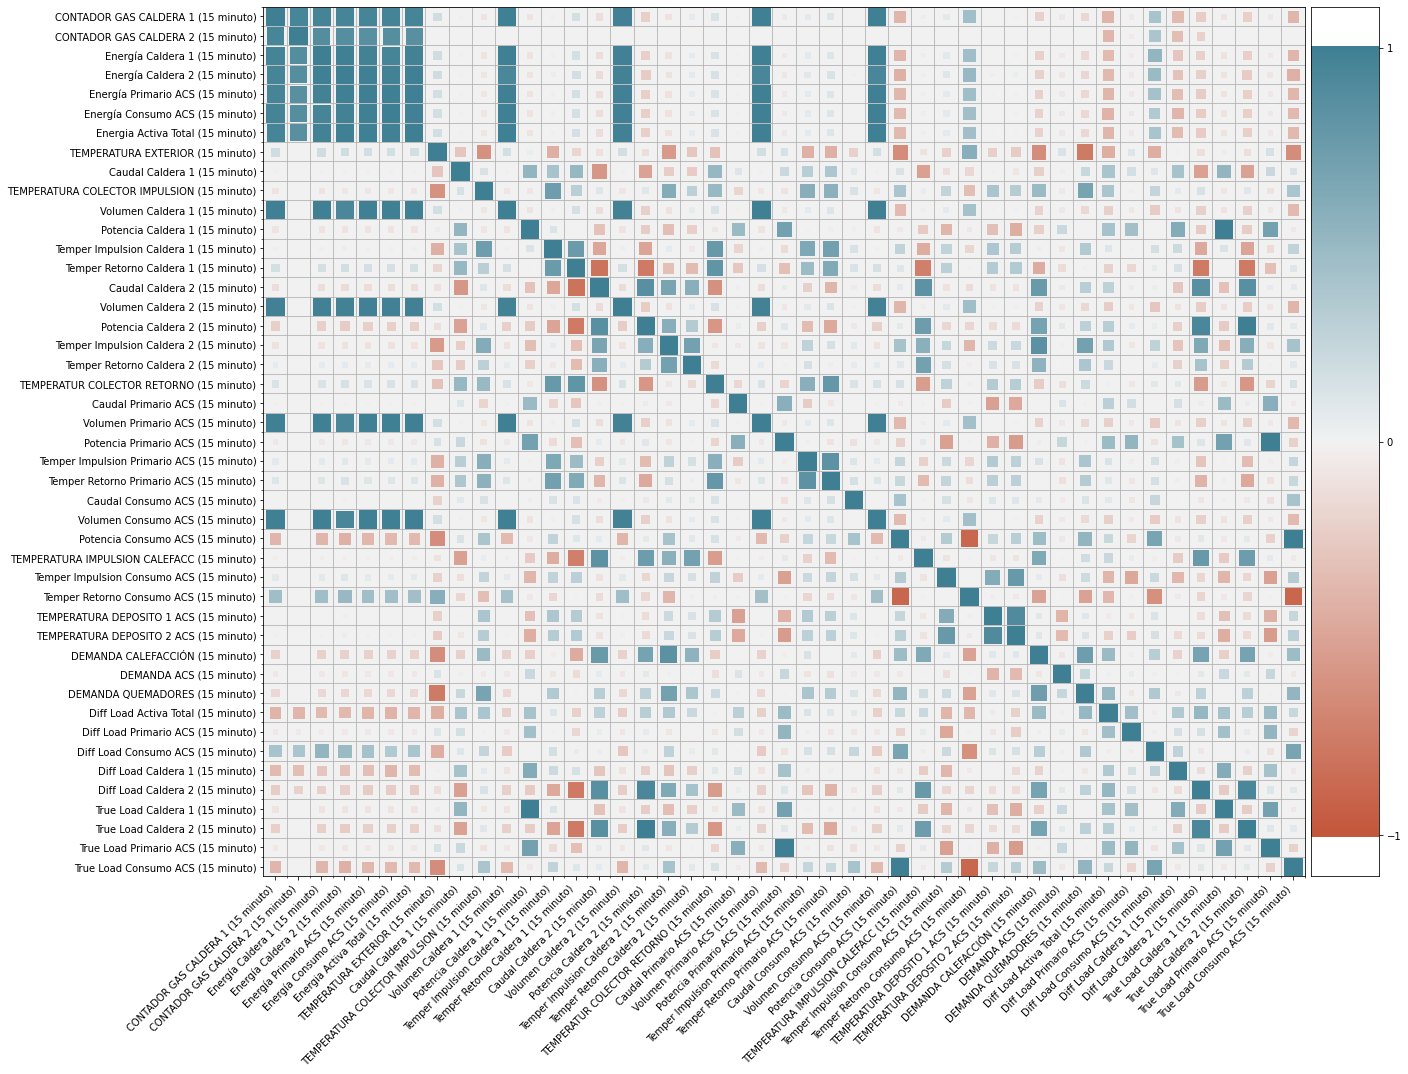

In [127]:
plt.figure(figsize=(20, 16))
corrplot(ts15.corr(), size_scale=300)

**Observations**
- High correlations are observed amongst the column of our interest (Total active load / Diff Load Activa Total) and the demand variables aka DEMANDA QUEMADORES, DEMANDA CALEFACCION, DEMANDA ACS. Howerver it needs to be validated that these variables truly refer to the respective energy demands of this systems as in the metadata excel file their units are mentioned as Celsius degrees.
- Similarly, positive but lower correlations are also present between the total active load and other variables the Diff Load variables which is expected if we suppose that the total load is additively built by this variables (ACS diff load is excluded). Similar correlation can be observed with other variables that are proportional to these loads (e.g Caudal Caldera x, TEMPERATURA COLLECTOR IMPULSION)
- Total load seems to be slightly negatively correlated to all energy variables (Energía) which is a behaviour that probably has occurred due to the differentiation in order to obtain loads.
- **The external temperature (TEMPERATURA EXTERIOR) seems to be negatively correlated with all load variables.  ACS consumed power (True Load Consumo ACS) is also negatively correlated which possibly raises a question mark if this variable contains cooling loads. However ACS primary load exhibits a slightly positive correlation. Further inspection is required here.**
- As expected True (mean power converted to energy demand) and Diff loads (differentiated total energy) also have high positive correlations as ideally the would be the same variable if precision of measurements was the same.

## Inter variable scatterplots
Scatterplots along with their regression lines are also illustrated amongst the most iteresting couples as described above. An extra observation here is that plots concerning the newly created diff load variables clearly exhibit the rounding effect which stems from the computation of these variables from low resolution energy measurements (measured in MWh with 2 decimal points). This effect is obvious from points distributed in a discrete manner.

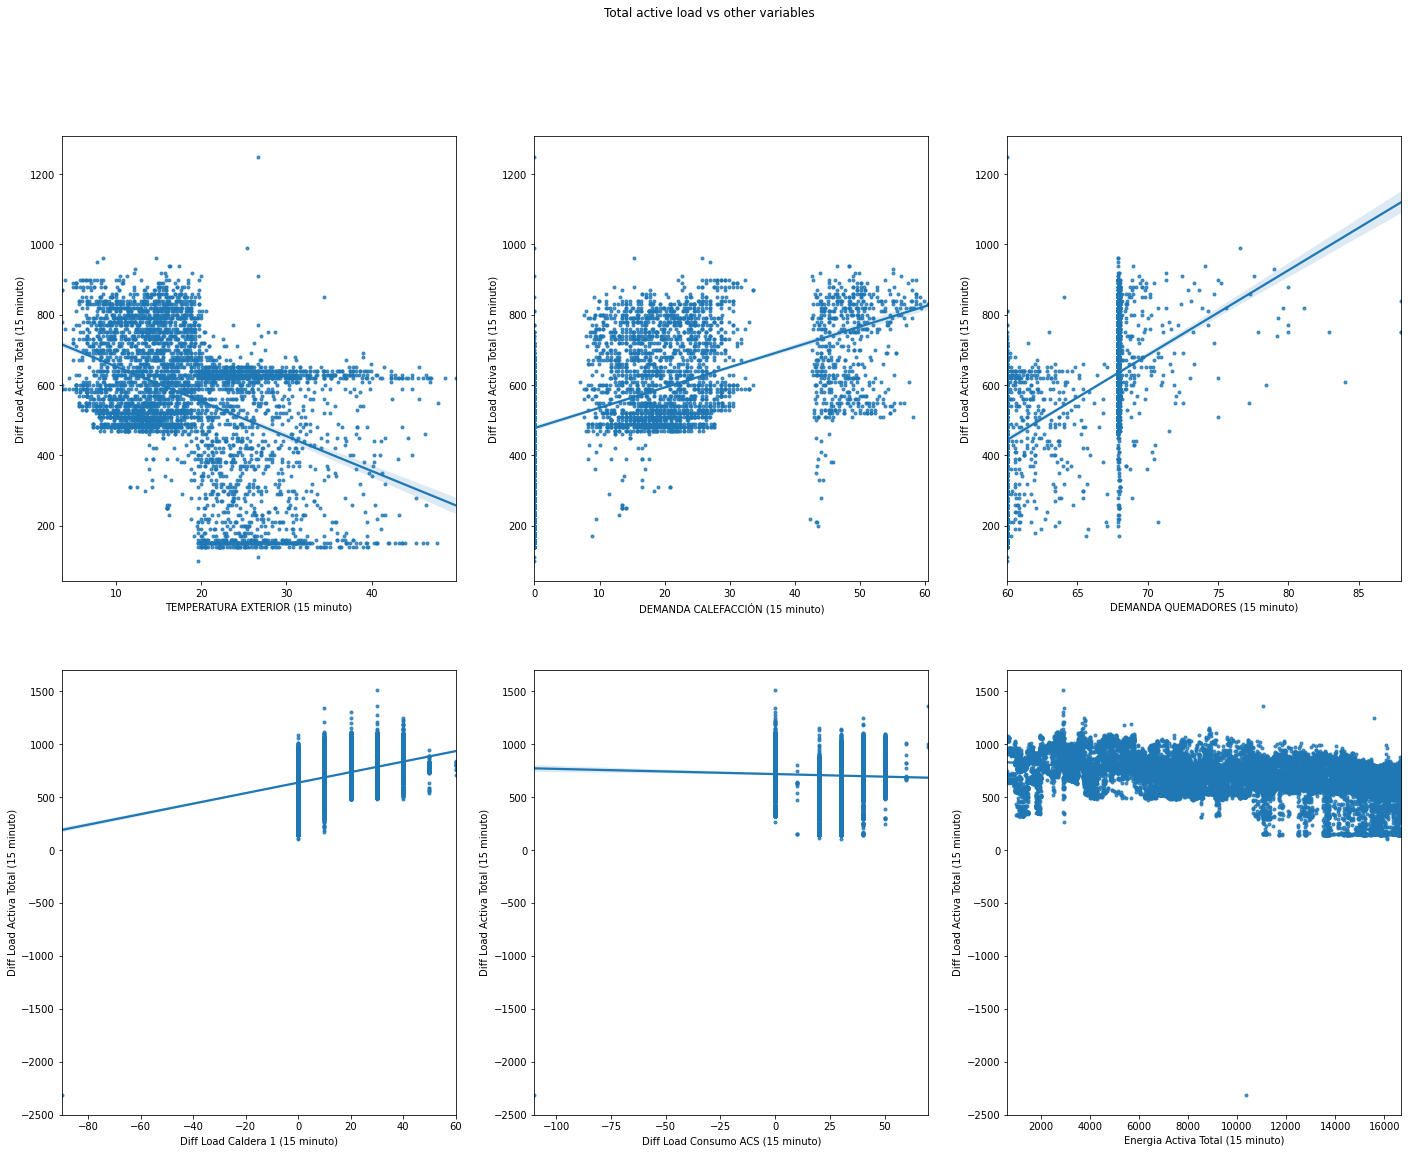

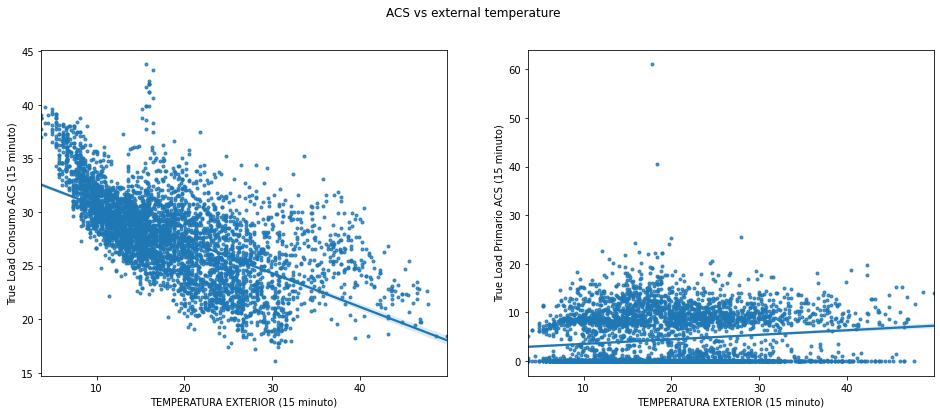

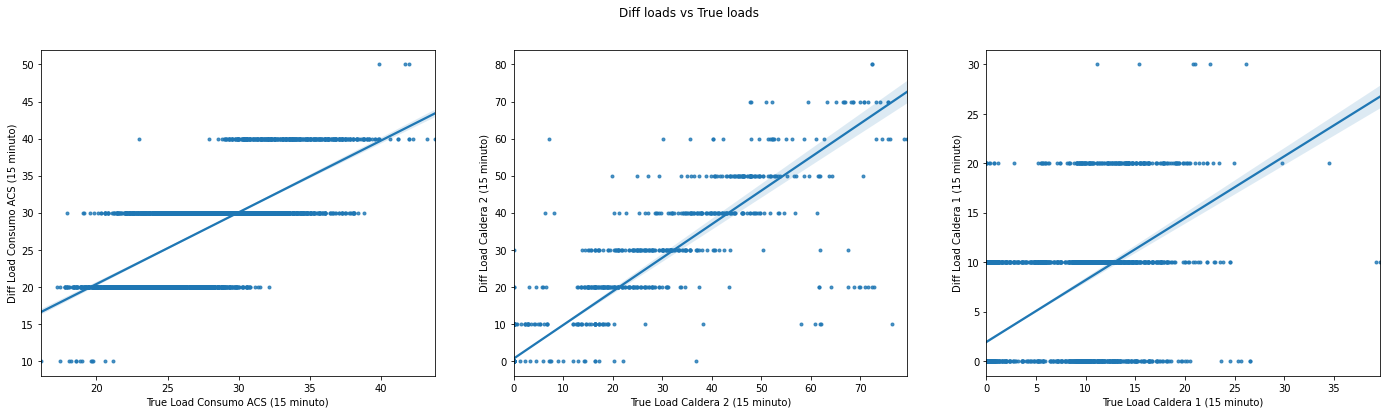

In [24]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(24, 18))
fig.suptitle('Total active load vs other variables')
sns.regplot(y="Diff Load Activa Total (15 minuto)", x="TEMPERATURA EXTERIOR (15 minuto)", data=ts15, marker='.', ax=axs[0, 0]);
sns.regplot(y="Diff Load Activa Total (15 minuto)", x="DEMANDA CALEFACCIÓN (15 minuto)", data=ts15, marker='.', ax=axs[0, 1]);
sns.regplot(y="Diff Load Activa Total (15 minuto)", x="DEMANDA QUEMADORES (15 minuto)", data=ts15, marker='.', ax=axs[0, 2]);
sns.regplot(y="Diff Load Activa Total (15 minuto)", x="Diff Load Caldera 1 (15 minuto)", data=ts15, marker='.', ax=axs[1, 0]);
sns.regplot(y="Diff Load Activa Total (15 minuto)", x="Diff Load Consumo ACS (15 minuto)", data=ts15, marker='.', ax=axs[1, 1]);
sns.regplot(y="Diff Load Activa Total (15 minuto)", x="Energia Activa Total (15 minuto)", data=ts15, marker='.', ax=axs[1, 2]);

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
fig.suptitle('ACS vs external temperature')
sns.regplot(y="True Load Consumo ACS (15 minuto)", x="TEMPERATURA EXTERIOR (15 minuto)", data=ts15, marker='.', ax=axs[0]);
sns.regplot(y="True Load Primario ACS (15 minuto)", x="TEMPERATURA EXTERIOR (15 minuto)", data=ts15, marker='.', ax=axs[1]);

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24,6))
fig.suptitle('Diff loads vs True loads')
sns.regplot(y="Diff Load Consumo ACS (15 minuto)", x="True Load Consumo ACS (15 minuto)", data=ts15, marker='.', ax=axs[0]);
sns.regplot(y="Diff Load Caldera 2 (15 minuto)", x="True Load Caldera 2 (15 minuto)", data=ts15, marker='.', ax=axs[1]);
sns.regplot(y="Diff Load Caldera 1 (15 minuto)", x="True Load Caldera 1 (15 minuto)", data=ts15, marker='.', ax=axs[2]);